In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fft import fft, ifft, fftfreq

In [49]:
NUM_PORTS = 4
SIZE = 200
imp0 = 377
connect = 50
tau = 0.3
kappa = 0.5 # not working yet for complex numnber

maxTime = 2000

N_seg = 6

sources = [[-1,-1],[0,2],[3,5],[2,0],[5,3],[2,4]]
couplings = [[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa]]

ez_tab = np.zeros([N_seg, maxTime, SIZE])

In [55]:
def gaussian(qTime):
    return np.exp(-(qTime - 30.) * (qTime - 30.) / 100.) /imp0

def cw(Time):
    return np.exp(-(qTime - 30.) * (qTime - 30.) / 100000000.) /imp0

In [51]:
class segment:
    def __init__(self, SIZE):
        self.ez = np.zeros([SIZE])
        self.hy = np.zeros([SIZE])
        self.sx = 49
        # self.source = source
        # self.tau = coupling[0]
        # self.kappa = coupling[1]
        
    def hy_update(self):
        self.hy[SIZE-1] = self.hy[SIZE-2] # simple ABC for hy
        for j in range(SIZE-1):
            self.hy[j] = self.hy[j] + (self.ez[j+1] - self.ez[j]) / imp0;
            
    def ez_update(self):
        for j in range(1,SIZE):
            self.ez[j] = self.ez[j] + (self.hy[j] - self.hy[j-1]) * imp0;
        self.ez[0] = self.ez[1]  # simple ABC for ez

    def hy_sources(self, s, sx):
        self.sx = sx
        self.hy[self.sx] -= s /imp0 
        
    def ez_sources(self, s,sx):   
        self.sx = sx
        self.ez[self.sx] += s      

In [56]:
f_array = []

for ii in range(N_seg):
    f = segment(SIZE)
    f_array.append(f)

for qTime in range(maxTime):
    s = cw(qTime)
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = coupling[ii][1]
       
        if (sources[ii][0] == -1):
            s_new = s
            xs = 50
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2 
            
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

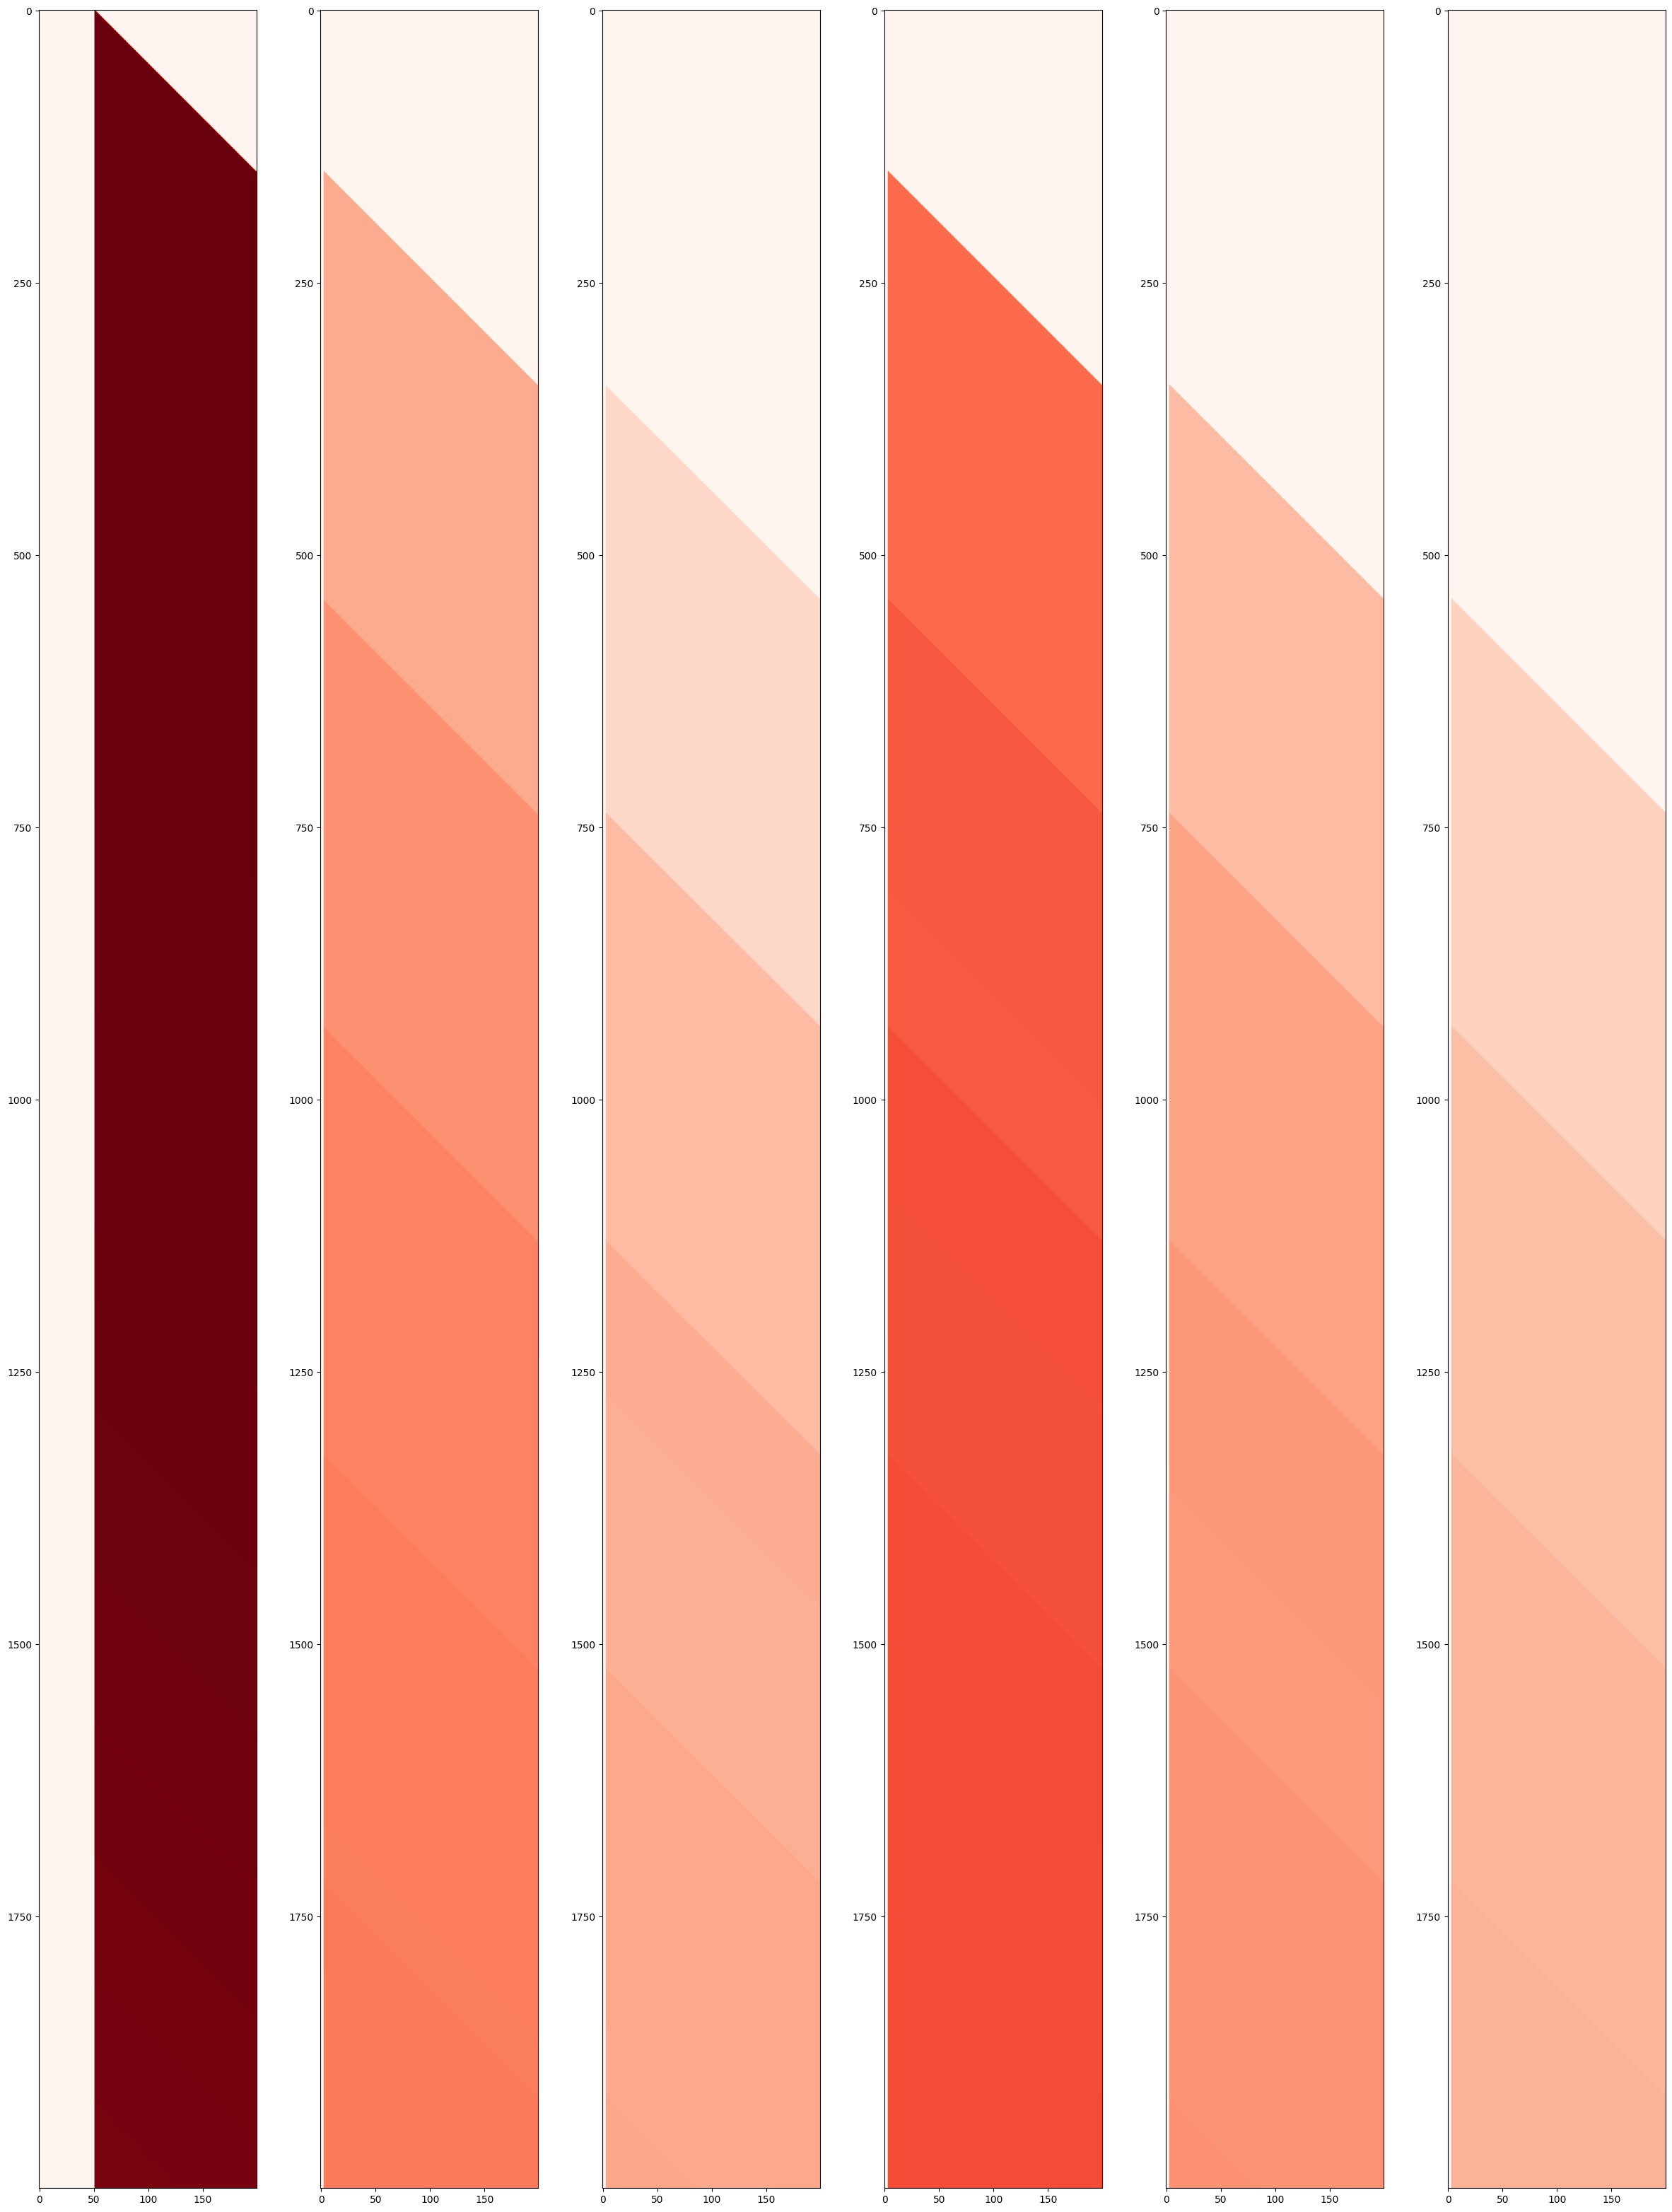

In [57]:
f, ax = plt.subplots(1,6, figsize=(30,40)) 

vmax_val = np.max(ez_tab[0,:,:])

for ii in range(N_seg):
    ax[ii].imshow(ez_tab[ii,:,:], vmin = 0, vmax = vmax_val , cmap = 'Reds')
    # plt.colorbar()
plt.show()

# plt.plot(ez_tab[:,15])